In [1]:
import math

import matplotlib.pyplot as plt
import torch

from utils import seed, get_train_dataloader, get_test_dataloader, model_to_log, split_x_train, load_data_phase, read_phase_file
from model import get_model, load_model
from norm_denorm import calculate_mean_disp, norm, denorm

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed(2)

In [2]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()
            # print('loss', epoch_loss, 'epoch', epoch)
                
            if phase == 'val' and best_val_loss > epoch_loss:
                print('New best val loss', epoch_loss, 'epoch', epoch)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

    return model

In [3]:
# hyperparameters
lr = 1e-3
epochs = 200
batch_size = 16
step_size = 20
gamma = 0.99
# parameters to be predicted
params = ['tb']  # 'V', 'D', 'tp', 'tb'

# path to folder and training set
train_folder = 'Data/DataField4.1'
# file name to save mean and variance for normalization
mean_disp_file = 'mean_disp.json'

# phase pattern size
phase_size = (64, 64)

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "params": '_'.join(params),
    "optim": 'Adam',
    "size": phase_size[0],
}
important_keys = ['optim', 'bs', 'params', "size"]
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

In [4]:
from norm_denorm import dump_mean_disp

mean, dispersion = calculate_mean_disp(train_folder, params)
print(mean, dispersion)

# maintaining the average and variance of usage with an already trained network
# dump_mean_disp(mean_disp_file, mean, dispersion)

[0.80670426] [0.00116788]


In [5]:
x_train, y_train = load_data_phase(train_folder, params, phase_size)
y_train = norm(y_train, mean, dispersion)

In [6]:
# path to folder and test set
test_folder = 'Data/TestCube'
x_test, y_test = load_data_phase(test_folder, params, phase_size)

# test set normalization
y_test = norm(y_test, mean, dispersion)
x_test, y_test = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), (x_test, y_test))

In [7]:
x_train, y_train, x_val, y_val = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), split_x_train(x_train, y_train, 64))

train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
test_dataloader = get_test_dataloader(x_val, y_val, batch_size)

val files [  2   7  12  20  24  25  28  32  53  55  67  77  84  89 114 119 129 131
 142 146 157 159 160 161 170 175 186 188 189 190 193 214 215 216 227 228
 235 236 241 244 264 270 274 279 286 294 297 306 321 328 332 334 337 339
 342 352 369 371 381 395 405 408 420 421]


In [8]:
model = get_model(x_train.size()[1:], len(params), device)

config['model'] = model_to_log(model)

loss_func = torch.nn.L1Loss()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [9]:
model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

New best val loss 0.6934292316436768 epoch 0
New best val loss 0.5191190540790558 epoch 2
New best val loss 0.43984078615903854 epoch 3
New best val loss 0.43285997211933136 epoch 8
New best val loss 0.3866128772497177 epoch 14
New best val loss 0.3787214234471321 epoch 16
New best val loss 0.3765985295176506 epoch 19
New best val loss 0.35840684175491333 epoch 27
New best val loss 0.34836794435977936 epoch 41
New best val loss 0.34243617951869965 epoch 46
New best val loss 0.32487400621175766 epoch 53
New best val loss 0.3203807845711708 epoch 60
New best val loss 0.31692133843898773 epoch 65
New best val loss 0.3084971718490124 epoch 86


In [10]:
best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), len(params), device)

In [11]:
y_val_result = best_model.forward(x_val).detach()
y_train_result = best_model.forward(x_train).detach()
y_test_result = best_model.forward(x_test).detach()

In [12]:
y_val_result_np = y_val_result.cpu().numpy()
y_train_result_np = y_train_result.cpu().numpy()
y_test_result_np = y_test_result.detach().cpu().numpy()

y_val_np = y_val.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

In [13]:
def add_subplot(fig, train, result, param_index, plot_index, label):
    
    sort = train[:, param_index].argsort(axis=0).reshape((-1,))
    ax_train = fig.add_subplot(3, 1, plot_index)
    ax_train.set_title(label=label, fontsize=12)
    ax_train.set_ylabel(param)
    ax_train.set_xlabel('num File')
    ax_train.plot(denorm(train[sort], mean, dispersion)[:, param_index], 'go', label='train')
    ax_train.plot(denorm(result[sort], mean, dispersion)[:, param_index], 'ro', label='result')
    ax_train.legend()
    
def show(param_index, param):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(f'Параметр {param}', fontsize=16)

    fig.subplots_adjust(hspace=0.4)
    
    add_subplot(fig, y_train_np, y_train_result_np, param_index, 1, 'Обучающий набор')
    add_subplot(fig, y_val_np, y_val_result_np, param_index, 2, 'Валидационный набор')
    add_subplot(fig, y_test_np, y_test_result_np, param_index, 3, 'Тестовый набор')

    plt.show()

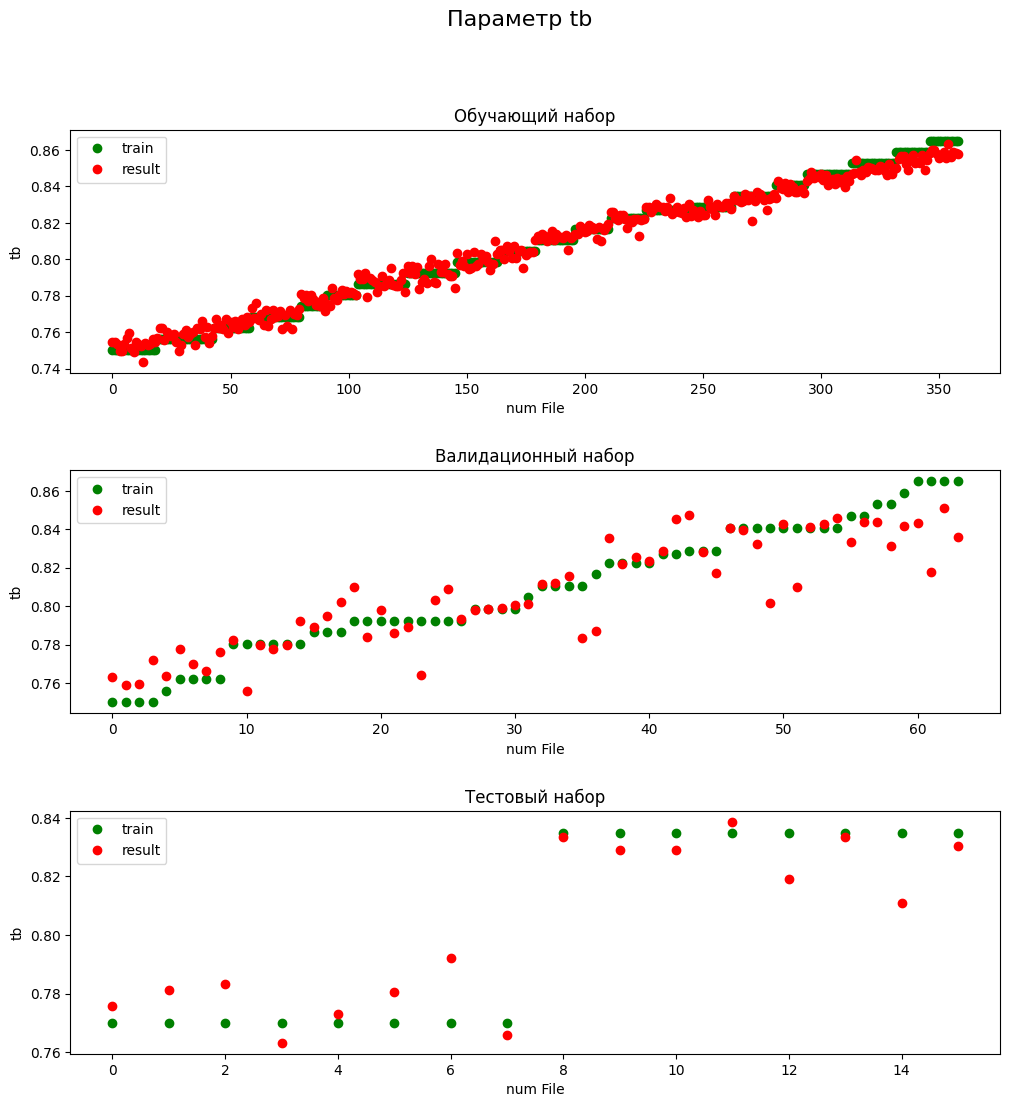

In [14]:
for param_index, param in enumerate(params):
    show(param_index, param)

In [15]:
def get_loss(result, real, i):
    error_m = torch.nn.MSELoss()(result[:, i], real[:, i]).item()
    error_a = torch.nn.L1Loss()(result[:, i], real[:, i]).item()
    return round(error_m, 6), round(error_a, 6)

def print_errors(i):
    train_error_m, train_error_a = get_loss(y_train_result, y_train, i)
    print('train error L1', train_error_a, 'MSE', train_error_m)
    val_error_m, val_error_a = get_loss(y_test_result, y_test, i)
    print('val error L1', val_error_a, 'MSE', val_error_m)
    test_error_m, test_error_a = get_loss(y_val_result, y_val, i)
    print('test error L1', test_error_a, 'MSE', test_error_m)

In [16]:
for param_index, param in enumerate(params):
    print(param, 'errors')
    print_errors(param_index)

tb errors
train error L1 0.093153 MSE 0.01369
val error L1 0.255652 MSE 0.103846
test error L1 0.308497 MSE 0.18926
